In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, classification_report

### imports for performing Random Search 
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV

%matplotlib inline

# Initial Model

## In this notebook, we'll walk through building and tuning an initial random forest classification model. Later, we will improve on this by incorporating additional features extracted with Natural Language Processing (NLP) techniques, as well as utilizing a Bayesian optimizer for model selection and hyperparameter tuning. This model will serve as a baseline for comparing later versions. 

In [2]:
### Start by loading the refined dataset

data = pd.read_csv("data/clean_data.csv", index_col=0)
target = pd.read_csv('data/target.csv', index_col=0)

In [3]:
### We want to remove three columns in our loaded dataset, which were included for future use in NLP notebooks. 

data.drop(['clean_desc', 'lem_tokens','lem_text'], axis=1, inplace=True)

## Model Features

Using the python file *process_df*, we have already cleaned up the original data, extracted new features, and removed columns that won't work with our classification model (i.e. non-categorical text fields). 

Below is a list of the remaining feature names. For now, you can review the meanings of the original columns in the EDA notebook, and the meaning of the engineered columns in the *feature engineering* notebook. Later, I will be adding those explanations in this notebook for easier access. 

#### Categorical columns in original data: 
fb_published, analytics, logo, map, member_type, header,channels, listed, payout_method, currency, country, delivery_method
#### Engineered categorical columns:
desc_has_link, org_has_link, email_suffix_code, country_match
#### Continuous columns in original data: 
body_length, name_length, user_age, org_facebook, org_twitter, sale_duration
#### Engineered continuous columns
num_tiers, tickets_available, average_ticket_price, avg_previous_payouts, num_previous_payouts, org_desc_len, venue_name_len, org_name_len

## One hot encoding
As per the lists above, we know several of our columns are categorical. We'll use one-hot encoding to convert these for use in our classification model. Every value within a categorical field will be assigned a binary column, with 1's in every row where that value occurred.

In [4]:
df_one_hot = data.copy()
df_one_hot.shape

(14337, 34)

In [5]:
### Here is a list of the categorical columns we need to convert
convert_cols = ['desc_has_link', 'org_has_link', 'email_suffix_code', 
            'country_match','fb_published', 'analytics', 'logo', 'map', 'member_type', 'header',
            'channels', 'listed', 'payout_method', 'currency', 'country', 'delivery_method']

In [6]:
df_one_hot = pd.get_dummies(data = df_one_hot, columns = convert_cols, prefix = convert_cols)

In [7]:
df_one_hot.shape

(14337, 148)

In [8]:
X = df_one_hot
y = target.fraud

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

## Random Search
This is an initial model, and we don't want to spend too much time optimizing parameters, given that we will be adjusting the model components in subsequent steps. That said, we want this model to be a good basis for comparison, which requires choosing reasonably good hyperparameters. Random search is a relatively quick option for optimization, so we'll use that for now.

In [9]:
# n_estimators
n_estimators = [int(x) for x in np.linspace(start = 800, stop = 1500, num = 10)]

# max_features
max_features = ['auto', 'sqrt']

# max_depth
max_depth = [int(x) for x in np.linspace(40, 70, num = 10)]
max_depth.append(None)

# class_weight
class_weight = ['balanced', None]

# min_samples_split
min_samples_split = [2, 5, 10]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# bootstrap
bootstrap = [True, False]

# Create the random grid
random_grid = {'class_weight': class_weight,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'class_weight': ['balanced', None],
 'max_depth': [40, 43, 46, 50, 53, 56, 60, 63, 66, 70, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [800, 877, 955, 1033, 1111, 1188, 1266, 1344, 1422, 1500]}


In [10]:
# First create the base model to tune
rfc = RandomForestClassifier(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=random_grid,
                                   n_iter=10,
                                   scoring='recall',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  6.0min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [12]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The recall of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'n_estimators': 800, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 66, 'class_weight': 'balanced', 'bootstrap': False}

The recall of a model with these hyperparameters is:
0.9255219011415805


### Fit the model on the training data & generate predictions for the test data

While the Random Search yielded the calculation of best 'recall' score, we want to see the model performance in greater depth. 

In [13]:
### Here we'll use the best hyperparameters found above
rfc = RandomForestClassifier(n_estimators=800, oob_score=True, random_state=33, class_weight='balanced', 
                             min_samples_leaf=4, min_samples_split=10, max_depth=66)

In [14]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=66, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=4,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=800, n_jobs=None, oob_score=True,
                       random_state=33, verbose=0, warm_start=False)

In [15]:
y_hat = rfc.predict(X_test)
y_hat = pd.Series(y_hat, index=X_test.index)

## Understanding the Results

In [16]:
from functions import actual_vs_predicted_counts

In [17]:
predicted_fraud, predicted_nf, actual_fraud, actual_nf = actual_vs_predicted_counts(y_hat, y_test)

print(f'The test set includes {actual_nf} non-fraudulent events & {actual_fraud} fraudulent events.')
print(f'The model predicted {predicted_nf} non-fraudulent events & {predicted_fraud} fraudulent events.')

The test set includes 2609 non-fraudulent events & 259 fraudulent events.
The model predicted 2616 non-fraudulent events & 252 fraudulent events.


### True or False?  Positive or Negative?

The language of *true positives* and *false negatives* is used to discuss several key measures of the quality of any classification model. If these terms aren't familiar, here's a quick recap: 

Recall that our 'y' variable indicates whether or not an event is fraudulent. *y_test* contains the actual values of y for each event in the test group, while *y_hat* contains the predictions (fraud or not fraud) that our model made for each event in the test set. 

A result is labeled 'True' if the model's prediction is accurate (AKA y_test and y_hat are the same for a specific event)
A result is labeled 'False' if the model's prediction is incorrect  (AKA y_test and y_hat are the different for a specific event)

In this case, positive/negative reflects whether the  model predicted fraud or not fraud. 

A result is labeled 'Positive' if the model predicts an event is fraudulent
A result is labeled 'Negative' if the model predicts an event is NOT fraudulent

In [18]:
tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
print(f'There are {tn} true negatives')
print(f'There are {fn} false negatives')
print(f'There are {tp} true positives')
print(f'There are {fp} false positives')

There are 2599 true negatives
There are 17 false negatives
There are 242 true positives
There are 10 false positives


### The results above tell us that the model made 2826 correct predictions (true positives + true negatives). We also see that the model missed 19 fraudulent events, and falsely suspected 23 real events. These numbers will be used to calculate several 'scores' used to measure & compare model performance. 

In [19]:
target_names = ['not fraud', 'fraud']
print(classification_report(y_test, y_hat, target_names = target_names))

              precision    recall  f1-score   support

   not fraud       0.99      1.00      0.99      2609
       fraud       0.96      0.93      0.95       259

    accuracy                           0.99      2868
   macro avg       0.98      0.97      0.97      2868
weighted avg       0.99      0.99      0.99      2868



### Precision Score : Out of all events predicted to be fraud, what percent is actually fraud? 
The precision score formula is true positives / (true positives + false positives)

### Recall Score : Out of all fraudulent events, what percent were correctly identified by model?
The recall score formula is true positives / (true positives + false negatives)

## Predicted Probabilities

So far, we have only looked at the model predictions in terms of 'Fraud' or 'Not Fraud'. The model actually calculates the probability that a given event is fraudulent. If the probability is .5 or above, the prediction is labeled 'Fraud'. Otherwise, it is labeled 'Not Fraud'.  

In [24]:
### The predict_proba method will give us an array with two columns (probability of not fraud, probability of fraud)
pred_prob = rfc.predict_proba(X_test)

### We will make a pandas series in order to index the predicted probabilities by IDs
pred_prob_fraud = pd.Series(pred_prob[:,1], index=X_test.index)

#### Now, instead of just knowing the counts of true positives, etc., we want to look at what probability the model assigned to each event... Specifically, we are interested in the probabilities for the events that were incorrectly classified. 

In [25]:
from functions import result_sets
tp_set, fp_set, tn_set, fn_set = result_sets(y_hat, y_test)

In [26]:
pred_prob_fraud[fp_set]

11488    0.635326
384      0.671959
12583    0.511809
4365     0.536370
1966     0.621044
12468    0.723382
8343     0.752333
506      0.718382
8155     0.608939
7967     0.894880
dtype: float64

In [27]:
pred_prob_fraud[fn_set]

12096    0.169328
7554     0.033541
4510     0.267263
8638     0.369047
2519     0.266564
4104     0.287447
11560    0.144238
6537     0.232978
7082     0.207805
11503    0.313629
11504    0.074367
10515    0.323575
5622     0.059058
2583     0.070586
11163    0.212940
9527     0.390345
12510    0.101951
dtype: float64

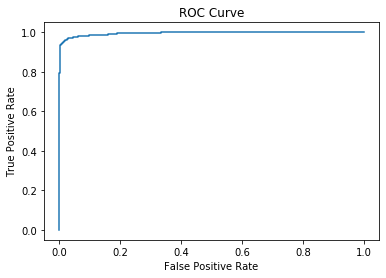

In [31]:
fpr, tpr, thresholds = roc_curve(y_test, pred_prob[:,1], pos_label=True)
plt.plot(fpr,tpr)
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [42]:
thresholds.shape

(104,)

In [35]:
actual_negatives = tn_set.union(fp_set)
actual_positives = tp_set.union(fn_set)

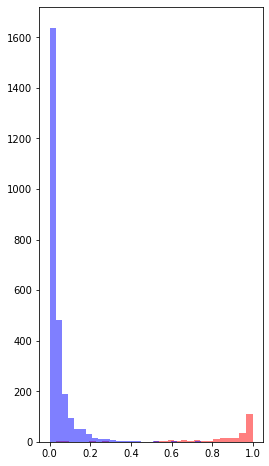

In [58]:
plt.figure(figsize=(4,8))
plt.hist(pred_prob_fraud[actual_positives], bins=30, alpha=.5, color='red')
plt.hist(pred_prob_fraud[actual_negatives], bins=30, alpha=.5, color = 'blue')
# plt.ylim(0, 100)

plt.show()

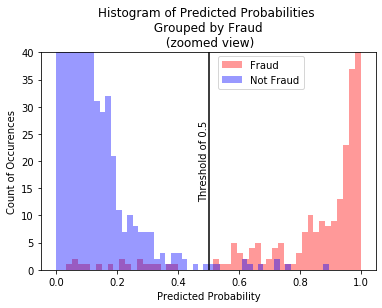

In [104]:
plt.figure(figsize=(6,4))
plt.hist(pred_prob_fraud[actual_positives], bins=50, alpha=.4, color='red')
plt.hist(pred_prob_fraud[actual_negatives], bins=50, alpha=.4, color = 'blue')
plt.legend(['Fraud', 'Not Fraud'], loc=(.53, .83))
plt.text(.47,13,'Threshold of 0.5', rotation=90)
plt.axvline(x=.5, color='black')
plt.ylim(0, 40)
plt.xlabel('Predicted Probability')
plt.ylabel('Count of Occurences')
plt.title('Histogram of Predicted Probabilities \n Grouped by Fraud \n (zoomed view)')

plt.show()

### Feature Importances

In [28]:
feat_imp = list(np.around(rfc.feature_importances_, 3))
feat_list = list(X_train.columns)

In [29]:
feat_imp_dict = {}
for t,r in zip(feat_list, feat_imp):
    feat_imp_dict[t] = r
feat_imp_dict

{'body_length': 0.03,
 'name_length': 0.012,
 'org_facebook': 0.046,
 'org_twitter': 0.023,
 'sale_duration': 0.1,
 'user_age': 0.069,
 'member_created': 0.029,
 'num_tiers': 0.006,
 'tickets_available': 0.01,
 'average_ticket_price': 0.023,
 'min_price': 0.021,
 'max_price': 0.019,
 'potential_revenue': 0.015,
 'org_desc_len': 0.008,
 'venue_name_len': 0.011,
 'org_name_len': 0.027,
 'avg_past_payouts': 0.16,
 'num_past_payouts': 0.168,
 'desc_has_link_False': 0.004,
 'desc_has_link_True': 0.006,
 'org_has_link_False': 0.001,
 'org_has_link_True': 0.002,
 'email_suffix_code_0': 0.002,
 'email_suffix_code_1': 0.002,
 'email_suffix_code_2': 0.003,
 'email_suffix_code_3': 0.0,
 'email_suffix_code_4': 0.0,
 'email_suffix_code_5': 0.0,
 'email_suffix_code_6': 0.0,
 'email_suffix_code_7': 0.002,
 'email_suffix_code_8': 0.0,
 'email_suffix_code_9': 0.0,
 'country_match_False': 0.009,
 'country_match_True': 0.01,
 'fb_published_0': 0.002,
 'fb_published_1': 0.002,
 'analytics_0': 0.001,
 'ana